- Loads the `cleaned_crime_data.csv` file for analysis.
- Identifies the top 10 most common criminal offenses within the dataset.
- Prepares the identified data for predictive modeling using the Prophet model.

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time  
import plotly.express as px





In [3]:
# load the cleaned_crime_data.csv
file_path = "../Resources/extended_nypd_crime_data.csv"
df = pd.read_csv(file_path)
df.head()

,ds,ofns_desc,boro_nm,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex
0,2010-01-01 00:00:00,RAPE,BROOKLYN,25-44,WHITE HISPANIC,M,<18,WHITE HISPANIC,F
1,2010-01-01 00:00:00,SEX CRIMES,BROOKLYN,18-24,UNKNOWN,F,<18,UNKNOWN,F
2,2010-01-01 00:00:00,OFF. AGNST PUB ORD SENSBLTY &,BRONX,25-44,WHITE HISPANIC,F,18-24,WHITE HISPANIC,F
3,2010-01-01 00:00:00,SEX CRIMES,BRONX,UNKNOWN,WHITE HISPANIC,M,<18,WHITE HISPANIC,F
4,2010-01-01 00:00:00,CRIMINAL MISCHIEF & RELATED OF,BROOKLYN,(null),(null),(null),(null),UNKNOWN,D


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6230868 entries, 0 to 6230867
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ds              object
 1   ofns_desc       object
 2   boro_nm         object
 3   susp_age_group  object
 4   susp_race       object
 5   susp_sex        object
 6   vic_age_group   object
 7   vic_race        object
 8   vic_sex         object
dtypes: object(9)
memory usage: 427.8+ MB


In [5]:
# Identifies the top 10 most common criminal offenses within the dataset.
common_offenses = df["ofns_desc"].value_counts().head(10)
common_offenses



ofns_desc
PETIT LARCENY                     1120973
HARRASSMENT 2                      848787
ASSAULT 3 & RELATED OFFENSES       673483
CRIMINAL MISCHIEF & RELATED OF     616129
GRAND LARCENY                      555028
DANGEROUS DRUGS                    291714
OFF. AGNST PUB ORD SENSBLTY &      288325
FELONY ASSAULT                     268562
ROBBERY                            212569
BURGLARY                           198312
Name: count, dtype: int64

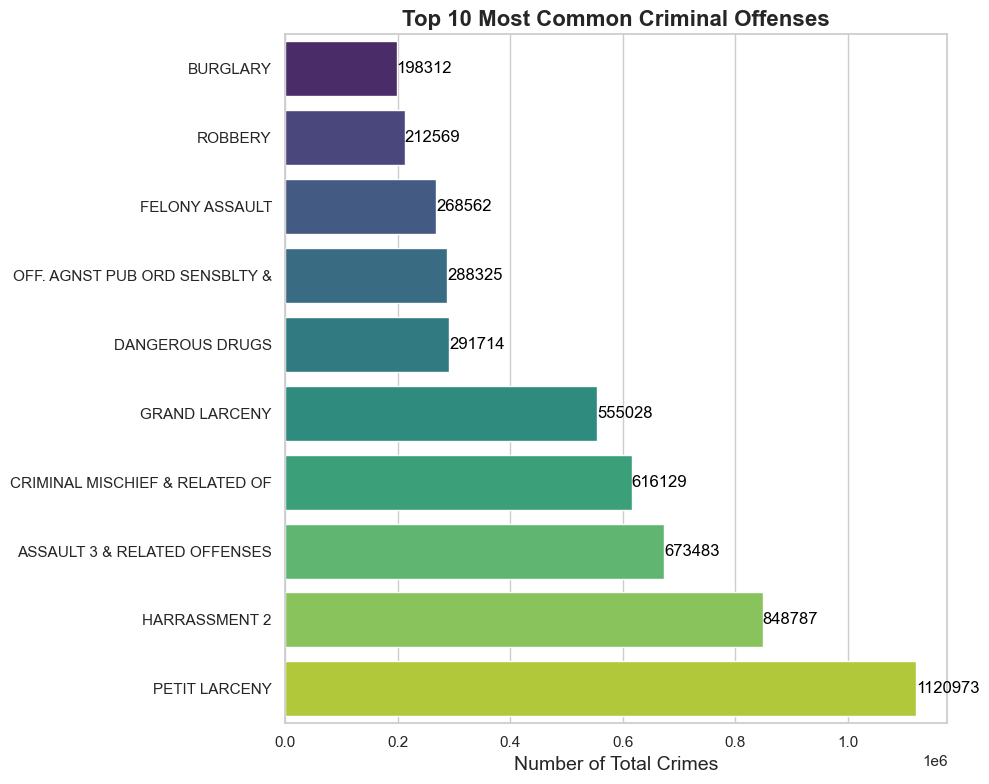

In [6]:
# Postavljanje Seaborn stila
sns.set(style="whitegrid")

# Konvertovanje Series objekta u DataFrame za lakše plotovanje
common_offenses_df = common_offenses.reset_index()
common_offenses_df.columns = ['Type of Offense', 'Number of Total Crimes']

# Sortiranje za bolju vizualizaciju
common_offenses_df.sort_values(by='Number of Total Crimes', inplace=True)

# Kreiranje grafikona
plt.figure(figsize=(10, 8))
sns.barplot(x='Number of Total Crimes', y='Type of Offense', data=common_offenses_df, palette='viridis')

# Dodavanje naslova i oznaka osa sa stilizovanjem
plt.title("Top 10 Most Common Criminal Offenses", fontsize=16, fontweight='bold')
plt.xlabel("Number of Total Crimes", fontsize=14)
plt.ylabel("")  # Uklanjamo labelu za y-osu jer je jasno iz konteksta

# Dodavanje vrednosti na stubove
for index, value in enumerate(common_offenses_df['Number of Total Crimes']):
    plt.text(value, index, str(value), color='black', va='center')

plt.tight_layout()  # Poboljšava raspored elemenata na grafikonu
plt.show()


In [7]:
# save the top 10 most common criminal offenses to a png file in Output folder
output_file_path = "../Output/top_10_most_common_offenses.png"


In [8]:
print(df.columns)

Index(['ds', 'ofns_desc', 'boro_nm', 'susp_age_group', 'susp_race', 'susp_sex',
       'vic_age_group', 'vic_race', 'vic_sex'],
      dtype='object')


In [9]:
# Pretvaranje 'ds' u datetime format ukoliko već nije
df['ds'] = pd.to_datetime(df['ds'])

Processing Top 10 Crimes: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


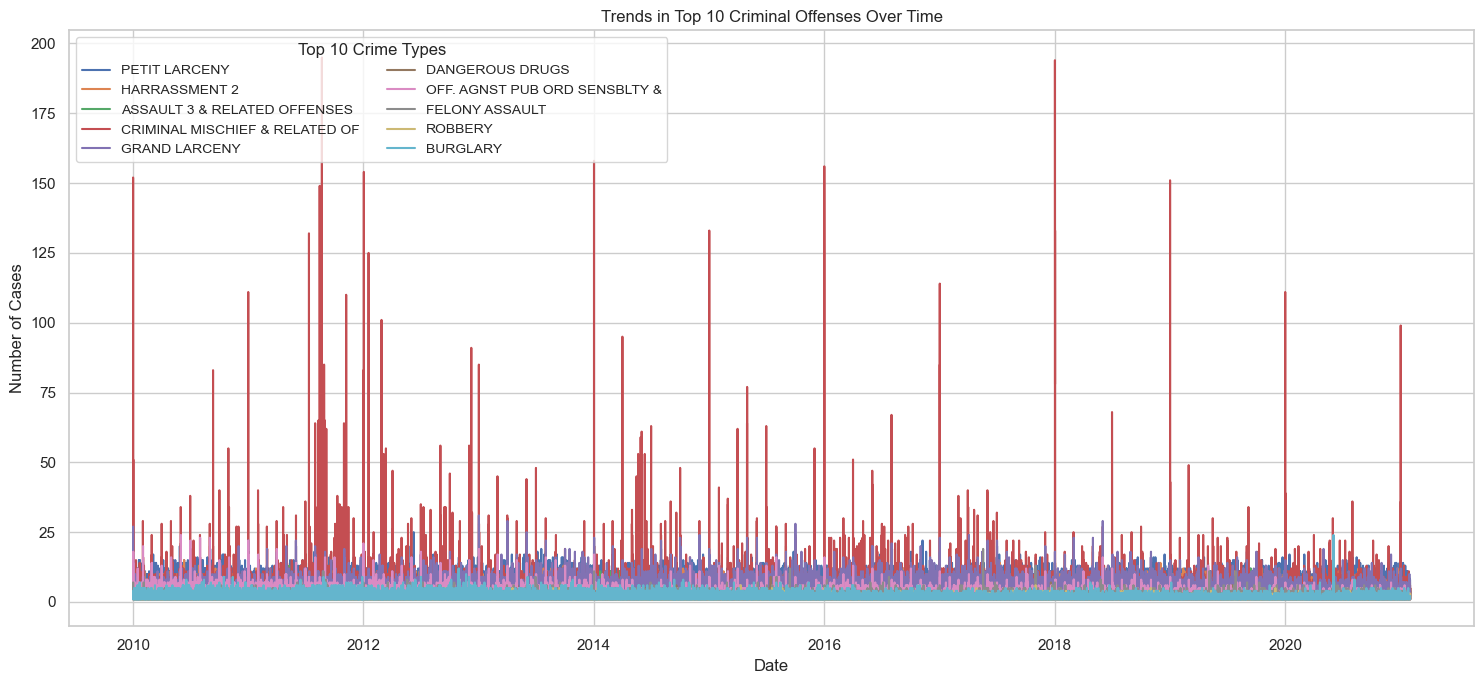

In [10]:


# Identifikacija top 10 zločina po frekvenciji
top_10_crimes = df['ofns_desc'].value_counts().head(10).index

plt.figure(figsize=(15, 7))

# Ograničavanje petlje na top 10 zločina
for crime_type in tqdm(top_10_crimes, desc='Processing Top 10 Crimes'):
    subset = df[(df['ofns_desc'] == crime_type) & 
                (df['ds'] >= pd.Timestamp('2010-01-01')) & 
                (df['ds'] <= pd.Timestamp('2021-01-31'))]
    subset = subset.groupby('ds')['ofns_desc'].count()
    plt.plot(subset.index, subset.values, label=crime_type)

# Smanjivanje broja legendi ili izostavljanje legende
plt.legend(loc='upper left', ncol=2, fontsize='small', title="Top 10 Crime Types")
plt.title('Trends in Top 10 Criminal Offenses Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.tight_layout()  # Poboljšava raspored elemenata na grafikonu
plt.show()


Processing Top 10 Crimes: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


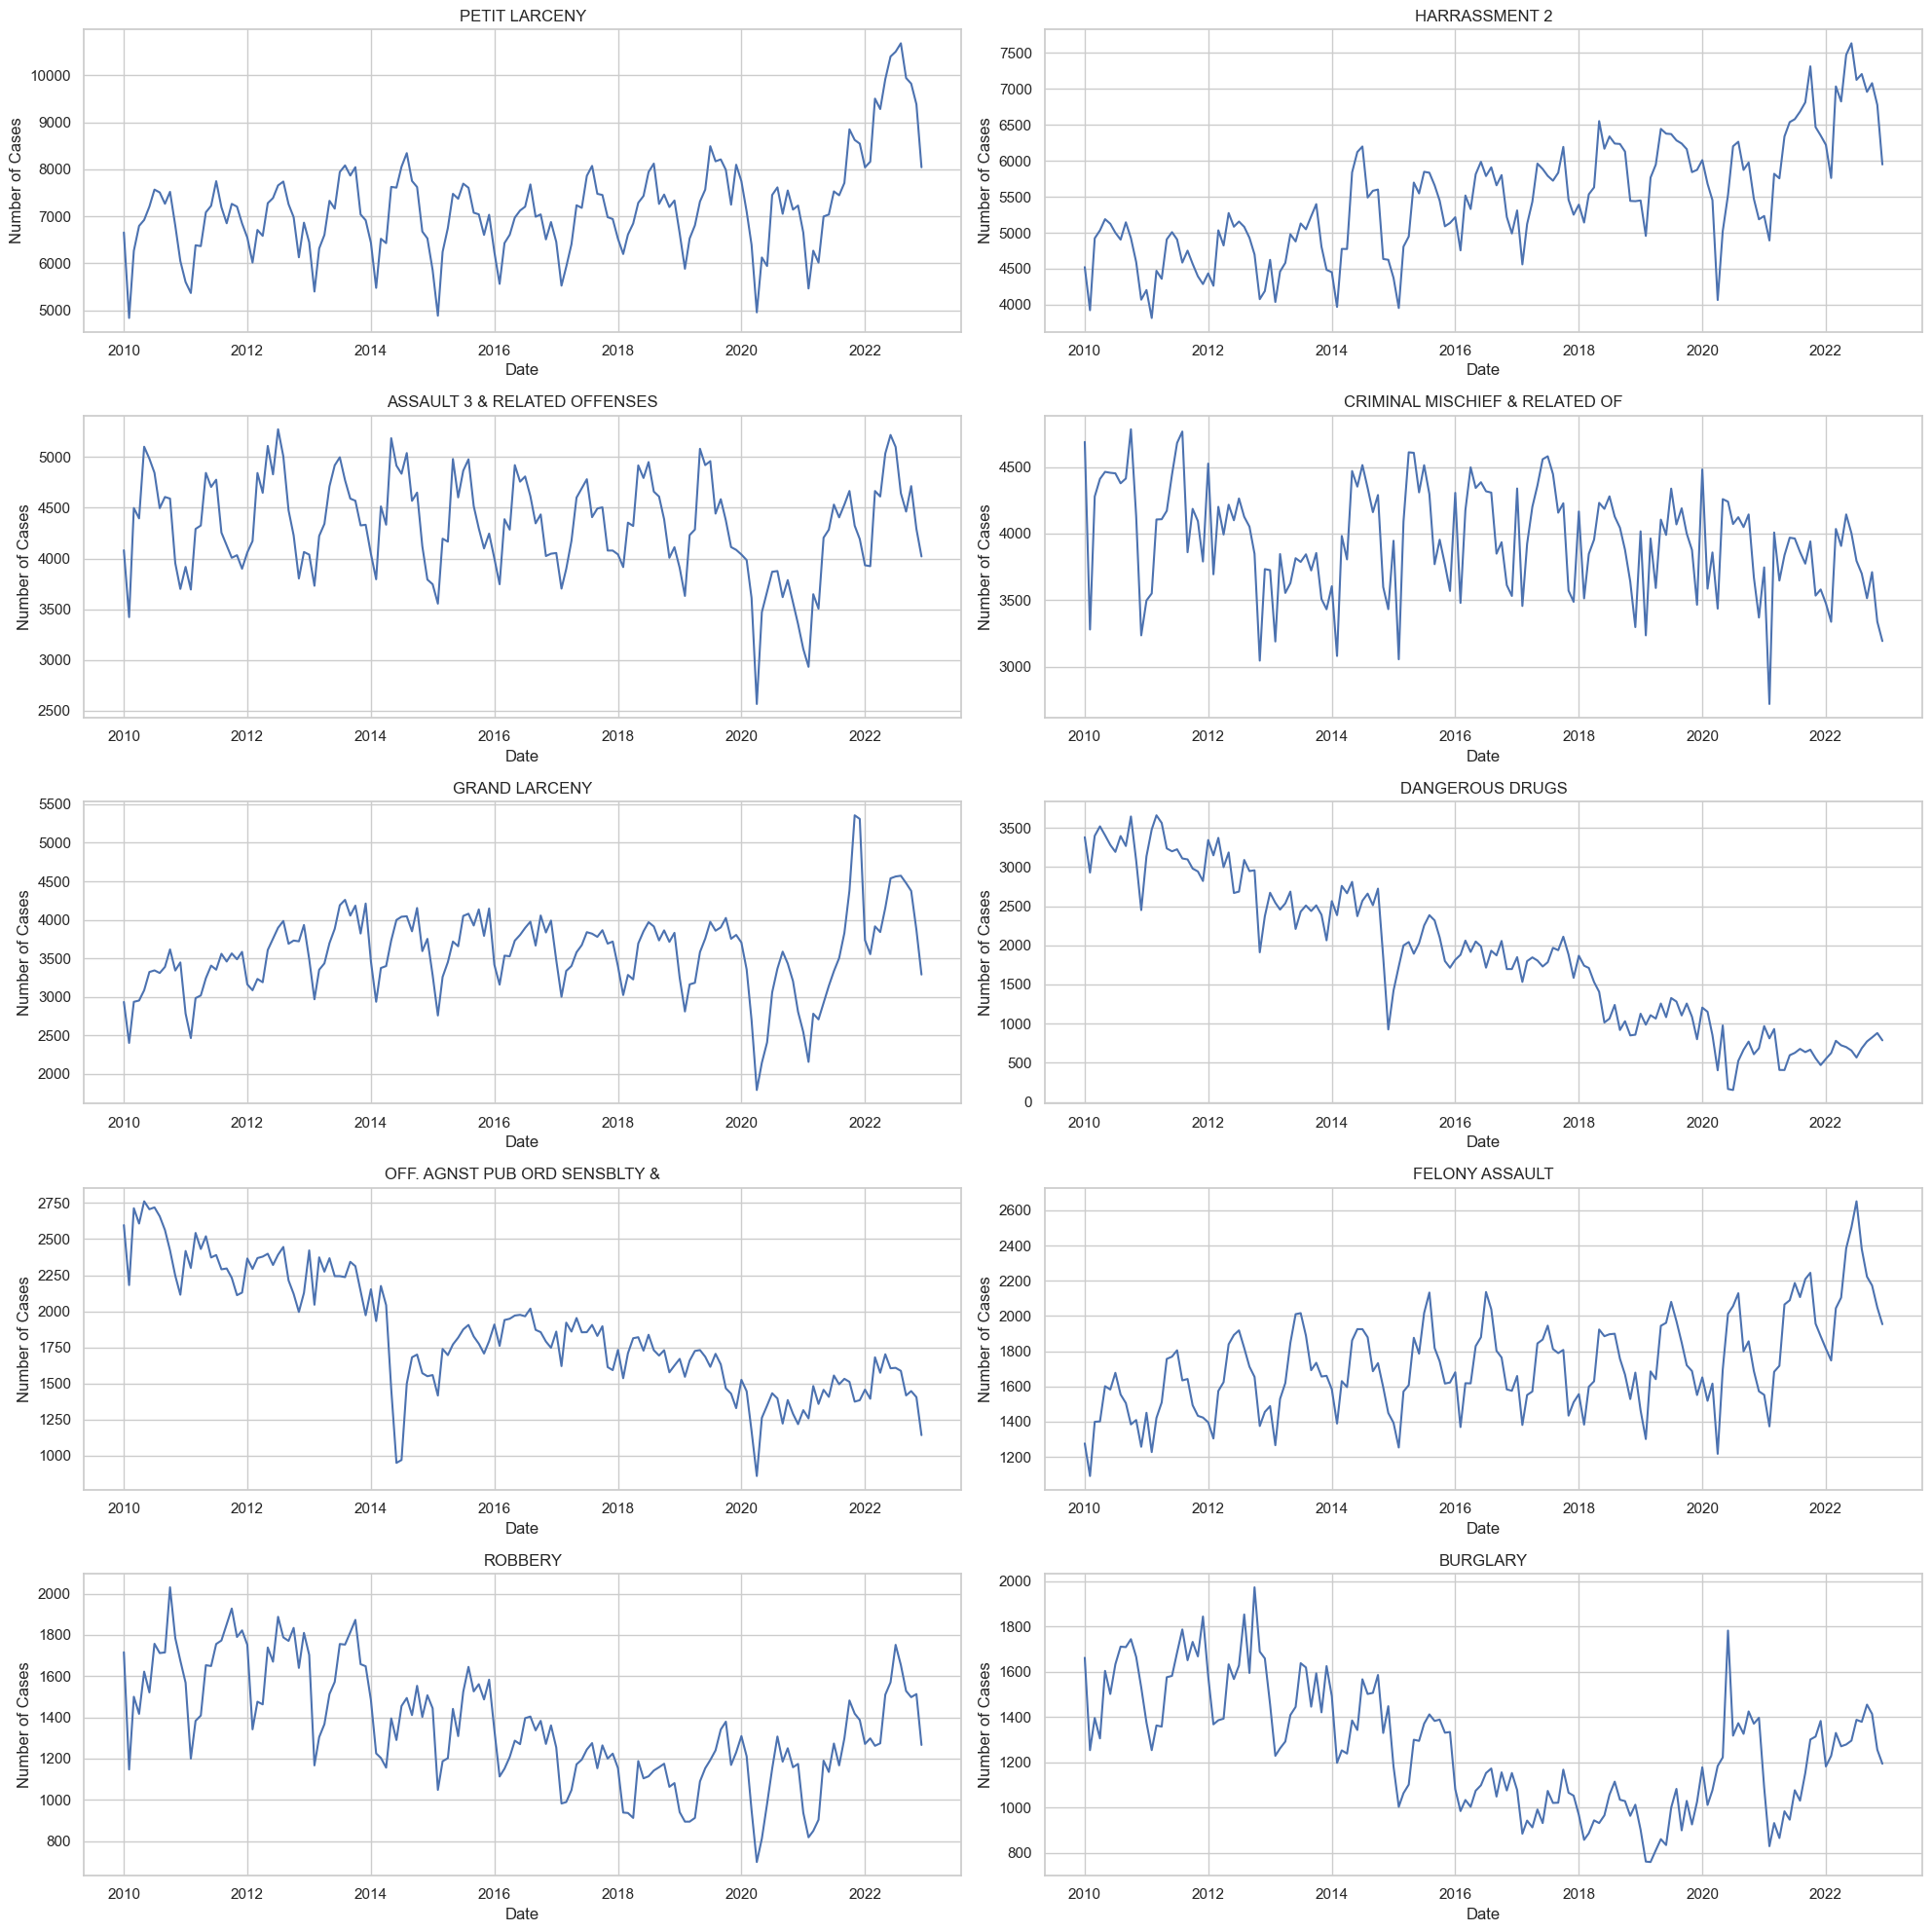

In [11]:
# Identifikacija top 10 zločina
top_10_crimes = df['ofns_desc'].value_counts().head(10).index.tolist()

# Kreiranje subplotova
fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # Podešavanje za 10 subplotova
axes = axes.flatten()  # Pretvaranje 2D niza u 1D niz za lakši pristup

for i, crime_type in enumerate(tqdm(top_10_crimes, desc='Processing Top 10 Crimes')):
    subset = df[df['ofns_desc'] == crime_type]
    subset = subset.groupby(subset['ds'].dt.to_period('M'))['ofns_desc'].count()
    subset.index = subset.index.to_timestamp()  # Konverzija PeriodIndex u DateTimeIndex za plotovanje
    axes[i].plot(subset.index, subset.values, label=crime_type)
    axes[i].set_title(crime_type)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Number of Cases')

plt.tight_layout()  # Poboljšava raspored elemenata na grafikonu
plt.show()


In [12]:
# Show ofns_desc
df['ofns_desc'].unique()


array(['RAPE', 'SEX CRIMES', 'OFF. AGNST PUB ORD SENSBLTY &',
       'CRIMINAL MISCHIEF & RELATED OF', 'GRAND LARCENY',
       'MISCELLANEOUS PENAL LAW', 'THEFT-FRAUD', 'PETIT LARCENY',
       'DANGEROUS WEAPONS', 'FRAUDS', 'DANGEROUS DRUGS',
       'POSSESSION OF STOLEN PROPERTY', 'HARRASSMENT 2',
       'OTHER OFFENSES RELATED TO THEF', 'OFFENSES INVOLVING FRAUD',
       'BURGLARY', 'FORGERY', 'NYS LAWS-UNCLASSIFIED FELONY',
       'CRIMINAL TRESPASS', 'ASSAULT 3 & RELATED OFFENSES', 'ROBBERY',
       'INTOXICATED & IMPAIRED DRIVING', 'VEHICLE AND TRAFFIC LAWS',
       'OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST THE PERSON',
       'FELONY ASSAULT', 'GRAND LARCENY OF MOTOR VEHICLE', 'ARSON',
       'ALCOHOLIC BEVERAGE CONTROL LAW', 'UNAUTHORIZED USE OF A VEHICLE',
       'MURDER & NON-NEGL. MANSLAUGHTER', 'ADMINISTRATIVE CODE',
       'KIDNAPPING & RELATED OFFENSES', 'OTHER STATE LAWS (NON PENAL LA',
       '(null)', 'OFFENSES AGAINST PUBLIC SAFETY', 'FRAUDULENT ACCOSTING',
 

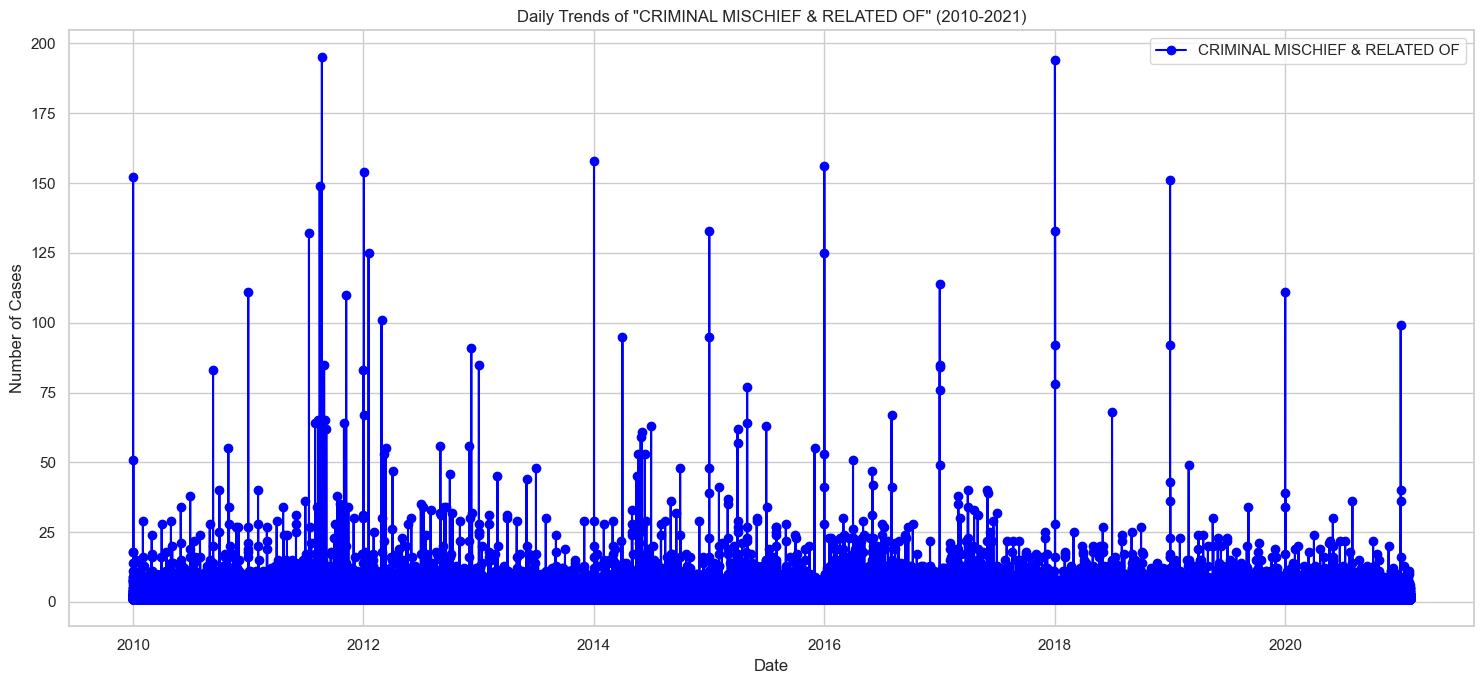

In [14]:
# Filtriranje podataka samo za "CRIMINAL MISCHIEF & RELATED OF"
cm_related_data = df[df['ofns_desc'] == "CRIMINAL MISCHIEF & RELATED OF"]

# Ograničavanje podataka na period od 2010 do 2021
cm_related_data = cm_related_data[(cm_related_data['ds'] >= pd.Timestamp('2010-01-01')) & 
                                  (cm_related_data['ds'] <= pd.Timestamp('2021-01-31'))]

# Grupisanje podataka po danima i brojanje slučajeva
daily_counts = cm_related_data.groupby('ds').size()

# Plotovanje podataka
plt.figure(figsize=(15, 7))
plt.plot(daily_counts.index, daily_counts.values, label='CRIMINAL MISCHIEF & RELATED OF', color='blue', marker='o', linestyle='-')

plt.legend()
plt.title('Daily Trends of "CRIMINAL MISCHIEF & RELATED OF" (2010-2021)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.tight_layout()
plt.show()

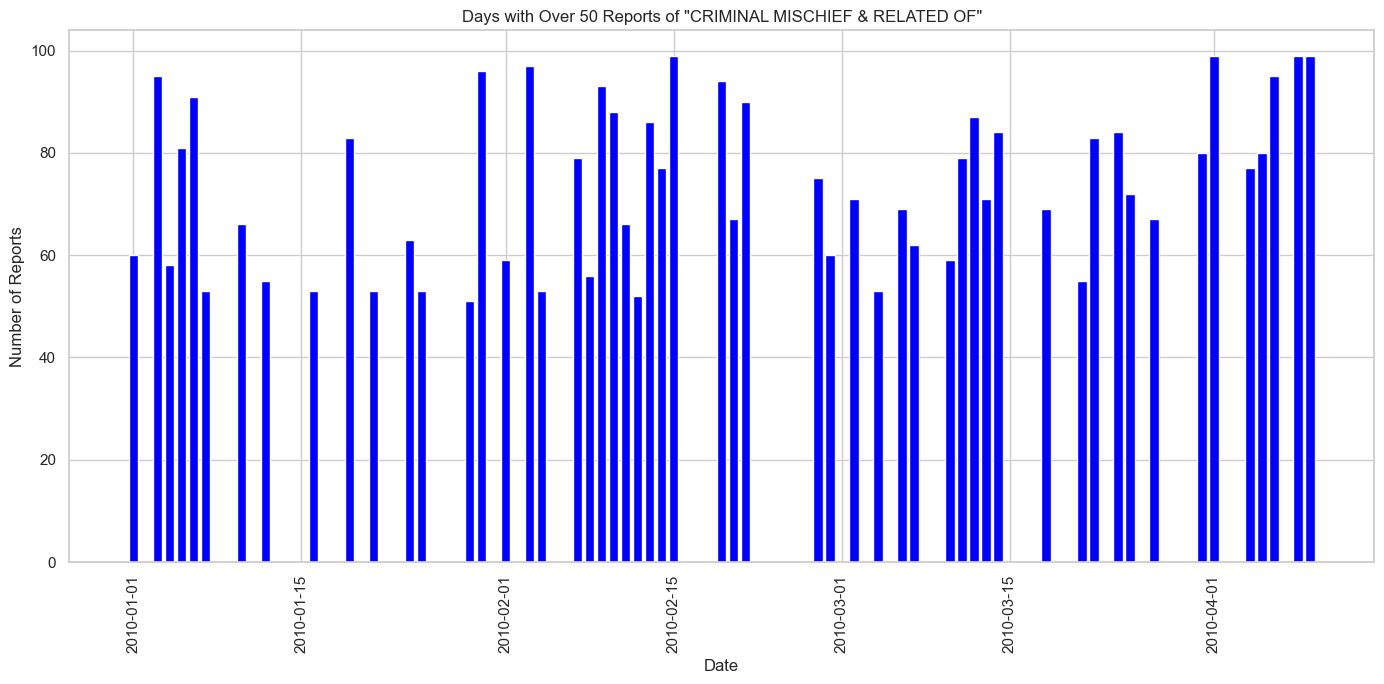

In [17]:
# For the purpose of this example, let's create a sample dataframe
# In your case, you should load your dataframe from a .csv file or other source
# df = pd.read_csv('your_file.csv')

# Sample data creation
data = {
    'ds': pd.date_range(start='2010-01-01', periods=100, freq='D'),
    'ofns_desc': ['CRIMINAL MISCHIEF & RELATED OF' for _ in range(100)],
    'incidents': np.random.randint(1, 100, size=100)  # Random number of incidents
}

df = pd.DataFrame(data)

# Now let's assume 'df' is your dataframe and it's loaded properly with 'ds' as datetime and 'ofns_desc' containing the offense descriptions

# Filter the data for "CRIMINAL MISCHIEF & RELATED OF" only
cm_related_data = df[df['ofns_desc'] == "CRIMINAL MISCHIEF & RELATED OF"]

# Convert 'ds' to datetime if it's not already in that format
cm_related_data['ds'] = pd.to_datetime(cm_related_data['ds'])

# Group by day and count the number of offenses
daily_counts = cm_related_data.groupby(cm_related_data['ds'].dt.date)['incidents'].sum()

# Filter days with more than 50 reports
days_over_50 = daily_counts[daily_counts > 50]

# Plotting the results
plt.figure(figsize=(14, 7))
plt.bar(days_over_50.index, days_over_50.values, color='blue')
plt.title('Days with Over 50 Reports of "CRIMINAL MISCHIEF & RELATED OF"')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.xticks(rotation=90)  # Rotate the x-axis labels to show the date clearly
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()

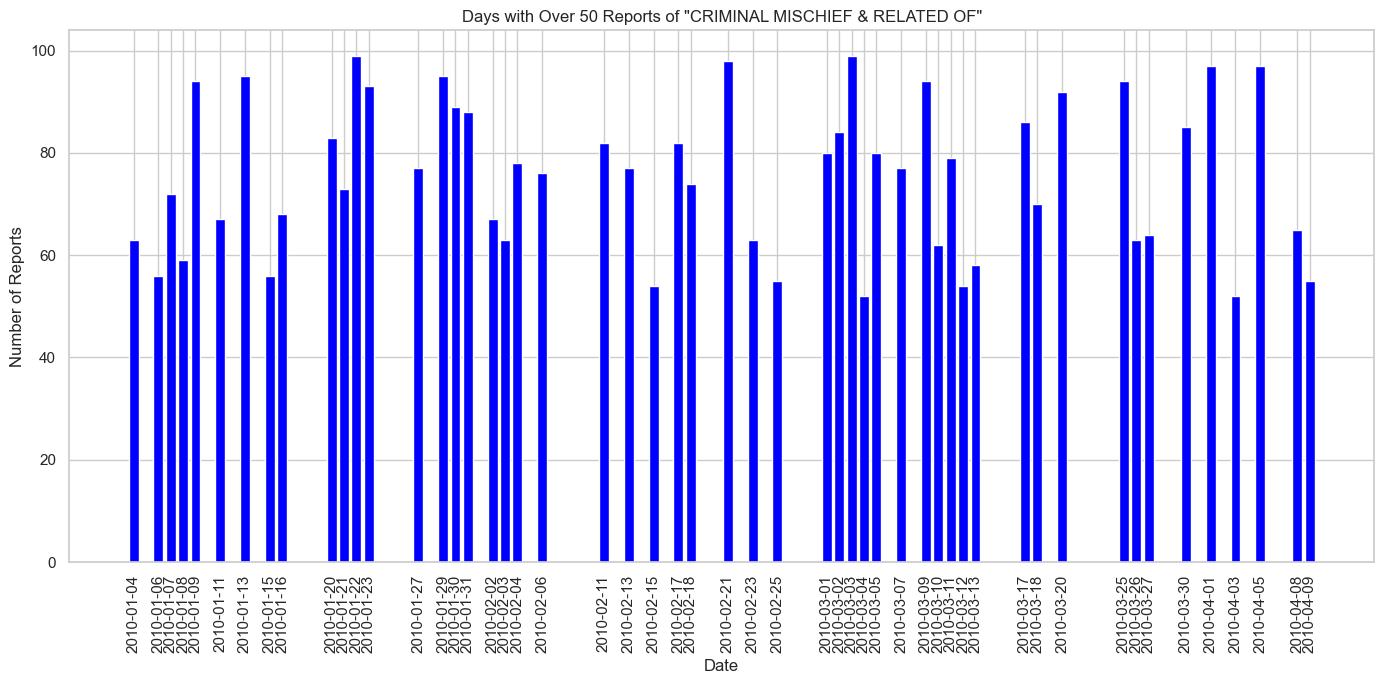

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For the purpose of this example, let's create a sample dataframe
# In your case, you should load your dataframe from a .csv file or other source
# df = pd.read_csv('your_file.csv')

# Sample data creation
data = {
    'ds': pd.date_range(start='2010-01-01', periods=100, freq='D'),
    'ofns_desc': ['CRIMINAL MISCHIEF & RELATED OF' for _ in range(100)],
    'incidents': np.random.randint(1, 100, size=100)  # Random number of incidents
}

df = pd.DataFrame(data)

# Assuming 'df' is your dataframe and it's loaded properly with 'ds' as datetime and 'ofns_desc' containing the offense descriptions

# Filter the data for "CRIMINAL MISCHIEF & RELATED OF" only
cm_related_data = df[df['ofns_desc'] == "CRIMINAL MISCHIEF & RELATED OF"]

# Convert 'ds' to datetime if it's not already in that format
cm_related_data['ds'] = pd.to_datetime(cm_related_data['ds'])

# Group by day and count the number of offenses
daily_counts = cm_related_data.groupby(cm_related_data['ds'].dt.date)['incidents'].sum()

# Filter days with more than 50 reports
days_over_50 = daily_counts[daily_counts > 50]

# Plotting the results
plt.figure(figsize=(14, 7))
bars = plt.bar(days_over_50.index, days_over_50.values, color='blue')

# Add date labels under each bar
plt.xticks(days_over_50.index, [date.strftime('%Y-%m-%d') for date in days_over_50.index], rotation=90)

plt.title('Days with Over 50 Reports of "CRIMINAL MISCHIEF & RELATED OF"')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()


In [19]:
days_over_50.info()


<class 'pandas.core.series.Series'>
Index: 52 entries, 2010-01-04 to 2010-04-09
Series name: incidents
Non-Null Count  Dtype
--------------  -----
52 non-null     int32
dtypes: int32(1)
memory usage: 2.7+ KB


In [22]:
# average dayli CRIMINAL MISCHIEF & RELATED OF
cm_related_data = df[df['ofns_desc'] == "CRIMINAL MISCHIEF & RELATED OF"]
cm_related_data = cm_related_data[(cm_related_data['ds'] >= pd.Timestamp('2010-01-01')) & 
                                  (cm_related_data['ds'] <= pd.Timestamp('2021-01-31'))]
daily_counts = cm_related_data.groupby('ds').size()
daily_counts.mean()
daily_counts.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 100 entries, 2010-01-01 to 2010-04-10
Series name: None
Non-Null Count  Dtype
--------------  -----
100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
